<a href="https://colab.research.google.com/github/sak-90/FallDetection_MajorProject/blob/main/FallDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving acc_gyr.csv to acc_gyr.csv


In [4]:
import pandas as pd
import numpy as np
import io

df = pd.read_csv(io.BytesIO(uploaded['acc_gyr.csv']))
df.head()

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96800 entries, 0 to 96799
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   xAcc    96800 non-null  float64
 1   yAcc    96800 non-null  float64
 2   zAcc    96800 non-null  float64
 3   xGyro   96800 non-null  float64
 4   yGyro   96800 non-null  float64
 5   zGyro   96800 non-null  float64
 6   label   96800 non-null  object 
dtypes: float64(6), object(1)
memory usage: 5.2+ MB


In [27]:
from scipy.stats import skew
from scipy.stats import kurtosis

df['accSkewness'] = df[['xAcc', 'yAcc', 'zAcc']].apply(skew, axis=1)
df['gyroSkewness'] = df[['xAcc', 'yAcc', 'zAcc']].apply(skew, axis=1)
df['accKurtosis'] = df[['xAcc', 'yAcc', 'zAcc']].apply(kurtosis, axis=1)
df['gyroKurtosis'] = df[['xAcc', 'yAcc', 'zAcc']].apply(kurtosis, axis=1)

df.head()

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label,acc_norm,gyr_norm,accSkewness,gyroSkewness,accKurtosis,gyroKurtosis
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall,10.108581,4.985960,0.072795,0.072795,-1.5,-1.5
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall,9.537688,7.893098,0.098030,0.098030,-1.5,-1.5
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall,9.185761,6.751792,0.070786,0.070786,-1.5,-1.5
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall,9.317725,2.843343,0.072545,0.072545,-1.5,-1.5
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall,9.264567,1.310153,0.062587,0.062587,-1.5,-1.5


In [33]:
_df =

(96800, 13)

In [34]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


def preprocess_dataset(data, seed=69420):
    new_data = data.drop("label",axis=1).to_numpy().reshape(-1, 400, 12)
    labels = np.array(data.label.iloc[np.arange(0,data.shape[0], 400)])

    sm = SMOTE(random_state=seed)
    y = labels
    X, y = sm.fit_resample(new_data.reshape(-1, 400*12), y)

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # scale
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train.reshape(-1, 400*12))
    X_test = scaler.fit_transform(X_test.reshape(-1, 400*12))

    # reshape
    X_train = X_train.reshape(-1, 400, 12)
    X_test = X_test.reshape(-1, 400, 12)
    input_shape = X_train.shape[1:]
    seq_len, n_features = input_shape

    le = LabelEncoder()
    le.fit(np.unique(y_train))
    y_train = le.transform(y_train)
    y_test = le.transform(y_test)
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=13)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=13)

    X_train = X_train.reshape(-1, seq_len, n_features)
    X_test = X_test.reshape(-1, seq_len, n_features)

    return X_train, X_test, y_train, y_test, input_shape

In [35]:
X_train, X_test, y_train, y_test, input_shape = preprocess_dataset(df)

In [42]:
from tensorflow.keras import layers, models, optimizers

model = models.Sequential([
    layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(13, activation='sigmoid')
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

In [45]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
12/12 [==============================] - 0s 37ms/step - loss: 4.6496e-05 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 0.9917
Epoch 2/50
12/12 [==============================] - 0s 30ms/step - loss: 4.5714e-05 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 0.9917
Epoch 3/50
12/12 [==============================] - 0s 38ms/step - loss: 4.4931e-05 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 0.9917
Epoch 4/50
12/12 [==============================] - 0s 32ms/step - loss: 4.4169e-05 - accuracy: 1.0000 - val_loss: 0.0255 - val_accuracy: 0.9917
Epoch 5/50
12/12 [==============================] - 0s 34ms/step - loss: 4.3412e-05 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 0.9917
Epoch 6/50
12/12 [==============================] - 0s 24ms/step - loss: 4.2670e-05 - accuracy: 1.0000 - val_loss: 0.0254 - val_accuracy: 0.9917
Epoch 7/50
12/12 [==============================] - 0s 31ms/step - loss: 4.1943e-05 - accuracy: 1.0000 - val_loss: 0.0253 - val_ac

In [47]:
print("validation_loss", history.history['val_loss'][-1])
print("validation_accuracy", history.history['val_accuracy'][-1])

validation_loss 0.025681812316179276
validation_accuracy 0.9917355179786682


In [48]:
prediction = model.evaluate(X_test, y_test)
print("prediction_accuracy", prediction[1])

4/4 [==============================] - 0s 6ms/step - loss: 0.0257 - accuracy: 0.9917
prediction_accuracy 0.9917355179786682


<Axes: >

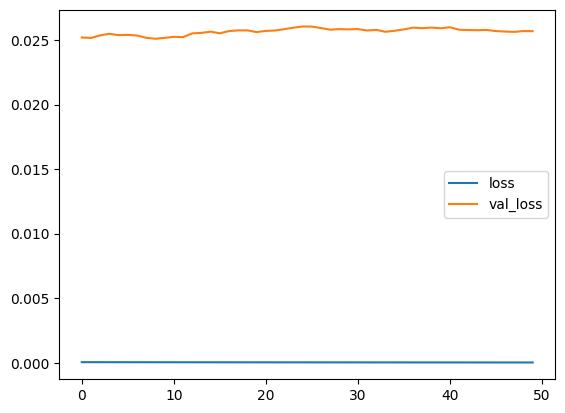

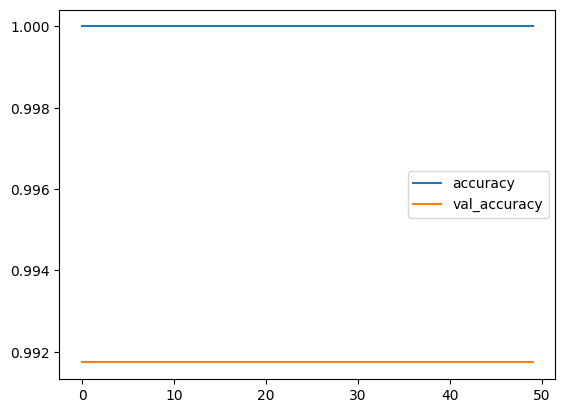

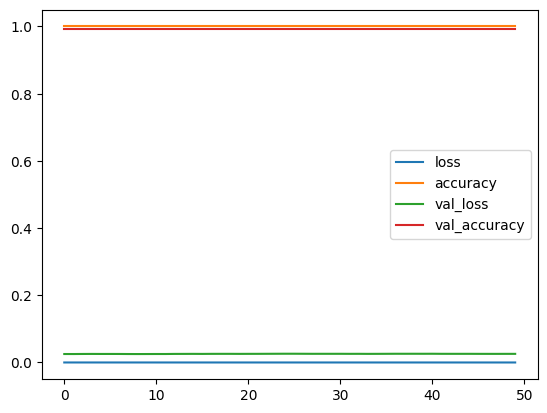

In [49]:
losses = pd.DataFrame(history.history)
losses.head()
losses[['loss','val_loss']].plot()
losses[['accuracy','val_accuracy']].plot()
losses.plot()